In [11]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
pd.set_option('display.max_columns', 500)


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
## read in csv files
data_2013 = pd.read_csv("../data/2012_13_loan_data/LoanStats3b.csv", low_memory = False, encoding='latin-1')

data_a_2014 = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv", low_memory = False);
data_b_2014 = pd.read_csv("../data/2014_loan_data/LoanStats_2014_B.csv", low_memory = False);
data_c_2014 = pd.read_csv("../data/2014_loan_data/LoanStats_2014_C.csv", low_memory = False);
data_d_2014 = pd.read_csv("../data/2014_loan_data/LoanStats_2014_D.csv", low_memory = False);

data_a_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_A.csv", low_memory = False);
data_b_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_B.csv", low_memory = False);
data_c_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_C.csv", low_memory = False);
data_d_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_D.csv", low_memory = False);
data_e_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_E.csv", low_memory = False);
data_f_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_F.csv", low_memory = False);
data_g_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_G.csv", low_memory = False);
data_h_2015 = pd.read_csv("../data/2015_loan_data/LoanStats_2015_H.csv", low_memory = False);


In [6]:
## concatenate data into training set
data_train = pd.concat([data_a_2014, data_b_2014, data_c_2014, data_d_2014, data_2013], ignore_index=True)

data_2015 = pd.concat([data_a_2015, data_b_2015, data_c_2015, data_d_2015, 
                       data_e_2015, data_f_2015, data_g_2015, data_h_2015], 
                       ignore_index=True)

In [46]:
# list(data_train.columns)

In [35]:
## Percent of loans that were fully paid but had non-zero delinquencies in the past 2 years
len(data_train[(data_train.delinq_2yrs > 0) & (data_train.loan_status == 'Fully Paid')])/float(len(data_train))

0.14769613678757595

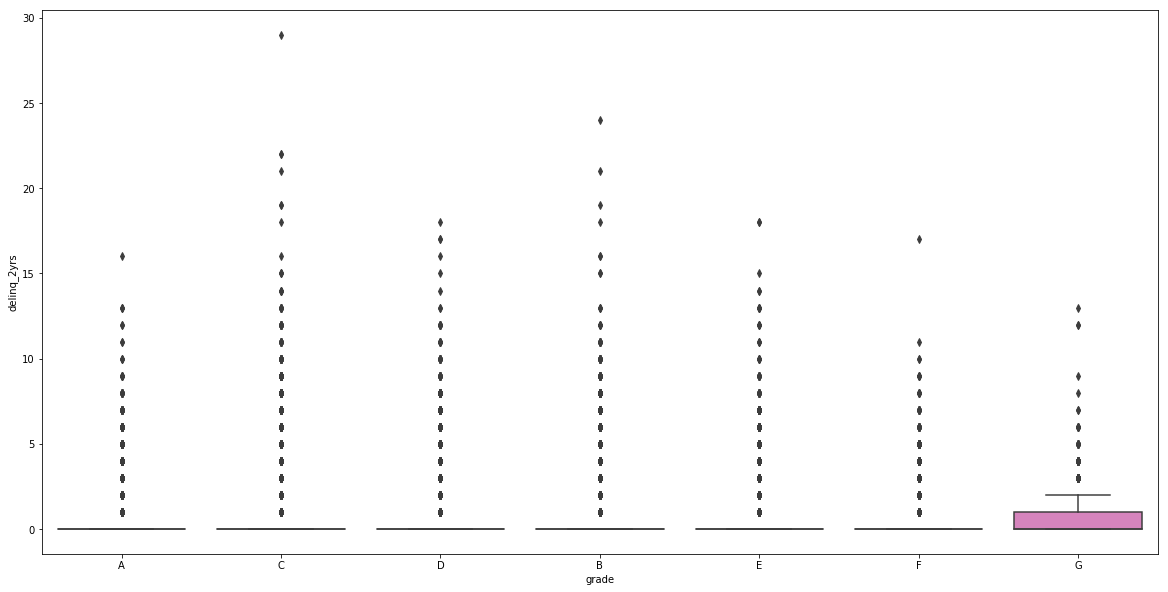

In [44]:
plt.figure(figsize = (20, 10))
sns.boxplot(y="delinq_2yrs", x="grade", data=data_train);

In [47]:
## checking for policy code 2 in train and test
assert sum(data_train.policy_code == 2) == 0
assert sum(data_2015.policy_code == 2) == 0

In [49]:
## Helper functions
def convert_dates(x):
    
    # Ignore dates with NaNs - will deal with it when taking difference
    if pd.isnull(x) is False:
        try:
            x = datetime.datetime.strptime(x,'%b-%y')
        except:
            x = datetime.datetime.strptime(x,'%b-%Y')
    return x

def diff_year(x, d1, d2):
    # Only change term for repaid loans
    if x['loan_status'] in ['Fully Paid', 'paid']:
        m = (d1.year - d2.year) + (d1.month - d2.month)/12
        
        # For loans that were fully paid back in the same month that they were issued,
        # assume they were repaid in 15 days
        if m == 0 and x['last_pymnt_amnt'] >= x['funded_amnt']:
            m = 0.04

    # For distressed loans, use original term in years
    else:
        m = 1/12 * x['terms_in_months']
    return m

def get_term_adj(df):
    
    # Apply date format
    df['issue_d1'] = df['issue_d'].apply(lambda x: convert_dates(x))
    df['last_pymnt_d1'] = df['last_pymnt_d'].apply(lambda x: convert_dates(x))
    
    # Get term in months
    df['terms_in_months'] = df['term'].apply(lambda x: int(x[1:3]))
    
    # Apply difference
    df['term_adj'] = df.apply(lambda x: diff_year(x, x['last_pymnt_d1'], x['issue_d1']), axis=1)
    
    # Drop helper cols
    df.drop(['terms_in_months', 'issue_d1','last_pymnt_d1'], axis=1)
    
    return df

def format_revol(val):
    percent = val[:-1]
    return float(percent)/100

def format_interest(val):
    percent = val[:-1]
    return float(percent)/100

def format_term(val):
    term = val[1:3]
    return float(term)/12

In [50]:
def initial_model(df, columns, columns_to_encode, columns_to_normalize):
    min_max_scaler = preprocessing.MinMaxScaler()
    new_df = df.copy()
    new_df = new_df[columns]
    new_df = pd.get_dummies(new_df, columns = columns_to_encode)
    new_df['amnt'] = new_df['funded_amnt']
    new_df[columns_to_normalize] = min_max_scaler.fit_transform(new_df[columns_to_normalize])
    return new_df

def clean_data(old_df):
    
    # Start with a fresh copy of the df
    df = old_df.copy()
    
    # Get adjusted term
    df = get_term_adj(df)
    
    # Drop cols with redacted identifying info
    columns_to_drop = ['id', 'member_id', 'emp_title']
    df = df.drop(columns_to_drop, axis = 1)
    
    # Cols to keep
    cols = ['funded_amnt', 'emp_length', 'home_ownership', 'int_rate', 'purpose', 'total_pymnt',
        'annual_inc', 'verification_status', 'dti', 'loan_status', 'revol_util', 'grade', 
            'term', 'term_adj', 'zip_code', 'delinq_2yrs']
    # Cols to one hot encode
    cols_encode = ['emp_length', 'home_ownership', 'verification_status', 'grade', 'purpose']
    # Cols to normalize
    cols_normalize = ['funded_amnt', 'annual_inc', 'dti']
    
    ## Apply initial model fn to clean the df
    df = initial_model(df, cols, cols_encode, cols_normalize)

    # Format using helper fns
    df['term'] = df['term'].map(format_term, na_action = 'ignore')
    df['int_rate'] = df['int_rate'].map(format_interest, na_action='ignore')
    df['revol_util'] = df['revol_util'].map(format_revol, na_action='ignore')
    
    # Mean imputation for revolving utilization and interest rate
    df[df['revol_util'].isnull()] = np.mean(df['revol_util'])
    df[df['int_rate'].isnull()] = np.mean(df['int_rate'])
    
    # Delete any current loans
    df = df[df.loan_status != 'Current']
    
    # Reduce loan status to a flag <-- RESPONSE VAR
    df['paid'] = 1;
    df.loc[df.loan_status == 'Fully Paid', 'paid'] = 0;
        
    return df

In [51]:
data_train = clean_data(data_train)
df_2015 = clean_data(data_2015)

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [52]:
## Note: Deleted the 1 row with educational purpose and column for educational purpose
df_2015 = df_2015[df_2015.purpose_educational != 1]
df_2015 = df_2015.drop(['purpose_educational'], axis = 1)

In [53]:
df_2015.columns == data_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [54]:
data_train.to_csv('cleaned_2013_14_upd', index = False)
df_2015.to_csv('cleaned_2015_upd', index = False)